# Consistent hashing 

1. In a distributed system where **nodes (servers) are frequently added or removed**, efficiently routing requests becomes challenging.

2. A common approach is to use hash the request and assign it to a server using **Hash(key) mod N** , where N is the number of servers.

3. However, this method is **highly dependent on the number of servers**, and any change in N can lead to significant rehashing, causing a **major redistribution of keys (requests)**.


In [1]:
from IPython.display import Image, display

**Consistent hashing addresses this issue by ensuring that only a small subset of keys need to be reassigned when nodes are added or removed.**

Popularized by Amazon’s Dynamo paper, it has now become a **fundamental technique in distributed databases** like DynamoDB, Cassandra and ScyllaDB.

# 1. The Problem with Traditional Hashing

1. Imagine you're building a high-traffic web application that serves millions of users daily. To handle the load efficiently, you distribute incoming requests across multiple backend servers using a hash-based load balancer.

2. Your system consists of 5 backend servers (S0, S1, S2, S3, S4), and requests are assigned using a hash function that maps each user's IP address to a specific server.

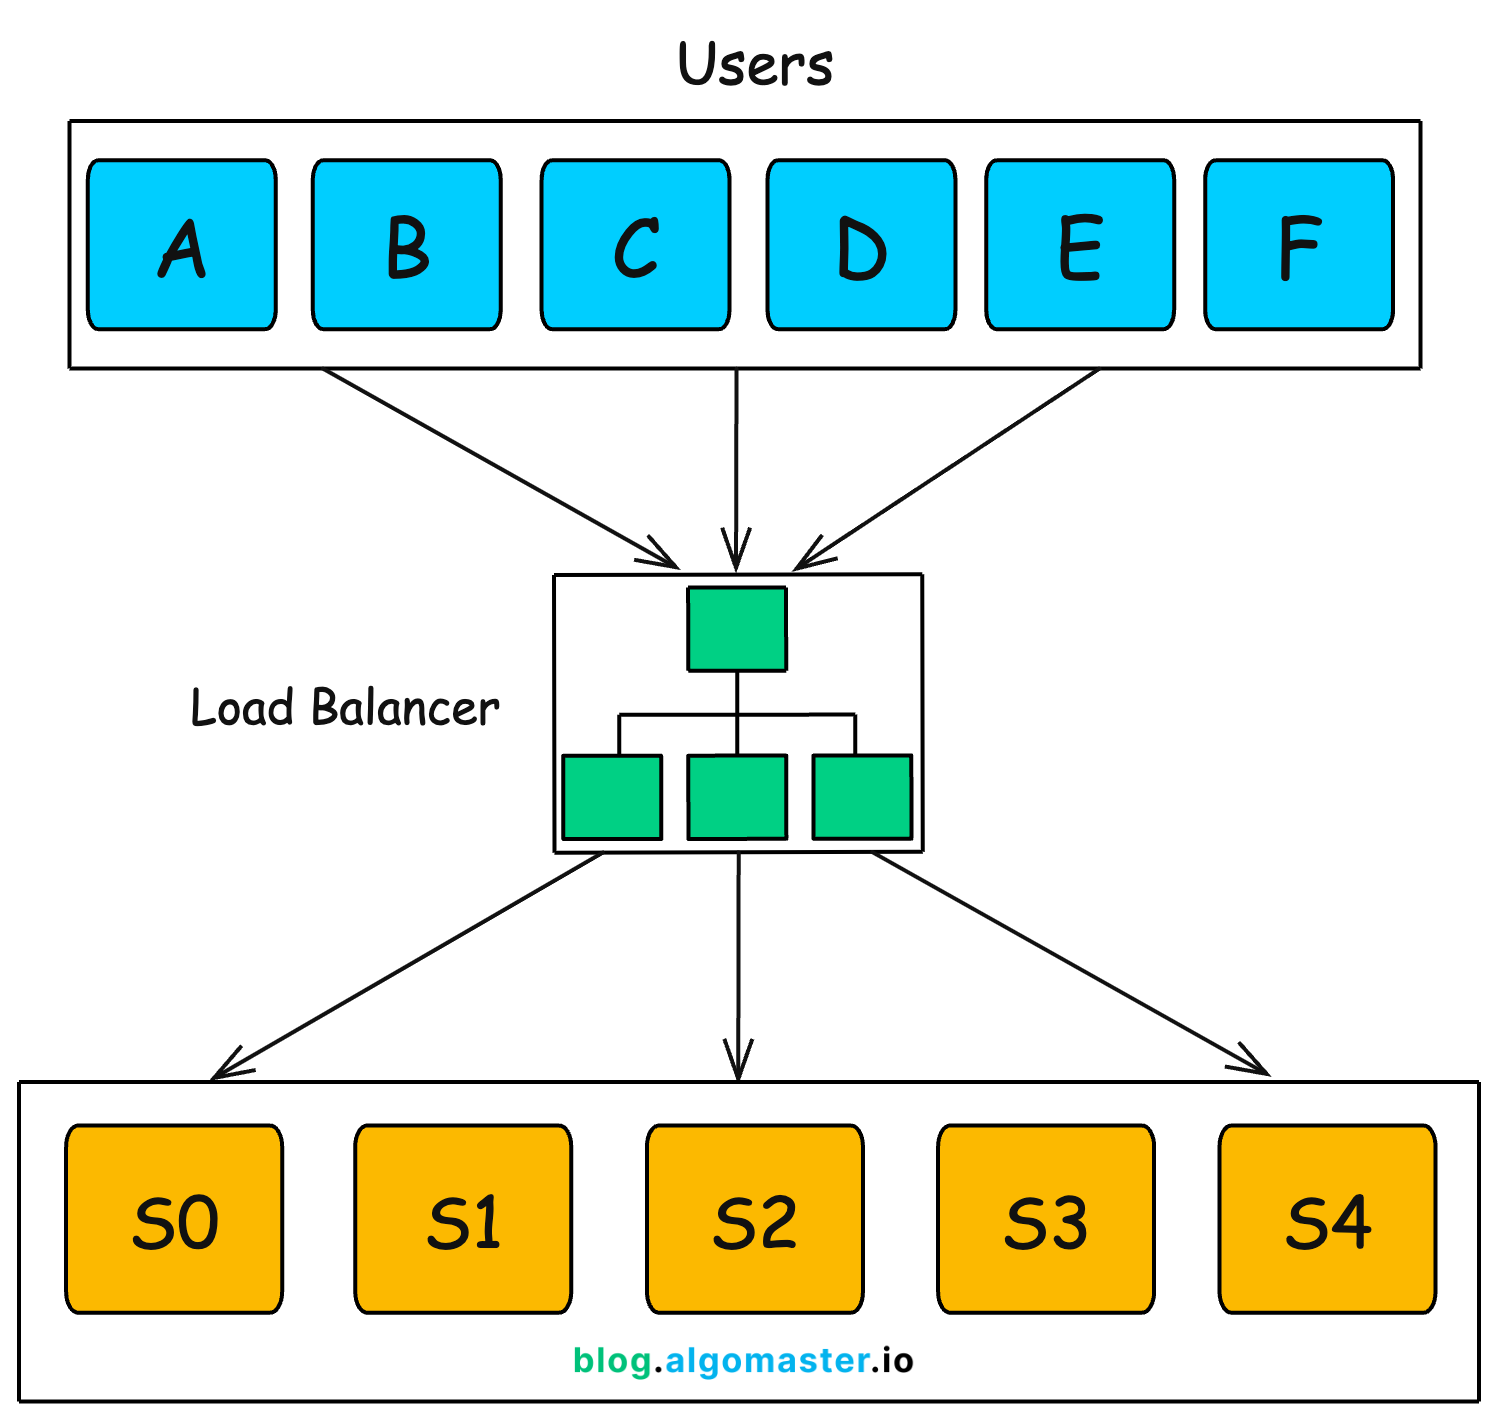

In [4]:
display(Image(filename='Utils/5.png'))

The process works like this:

1. The load balancer **takes a user’s IP address** (or session ID).

2. A hash function maps the IP to one of the backend servers by **taking the sum of bytes in the IP address** and computing mod 5 (since we have 5 servers).

3. The request is routed to the assigned server, ensuring that the **same user is always directed to the same server for session consistency**.

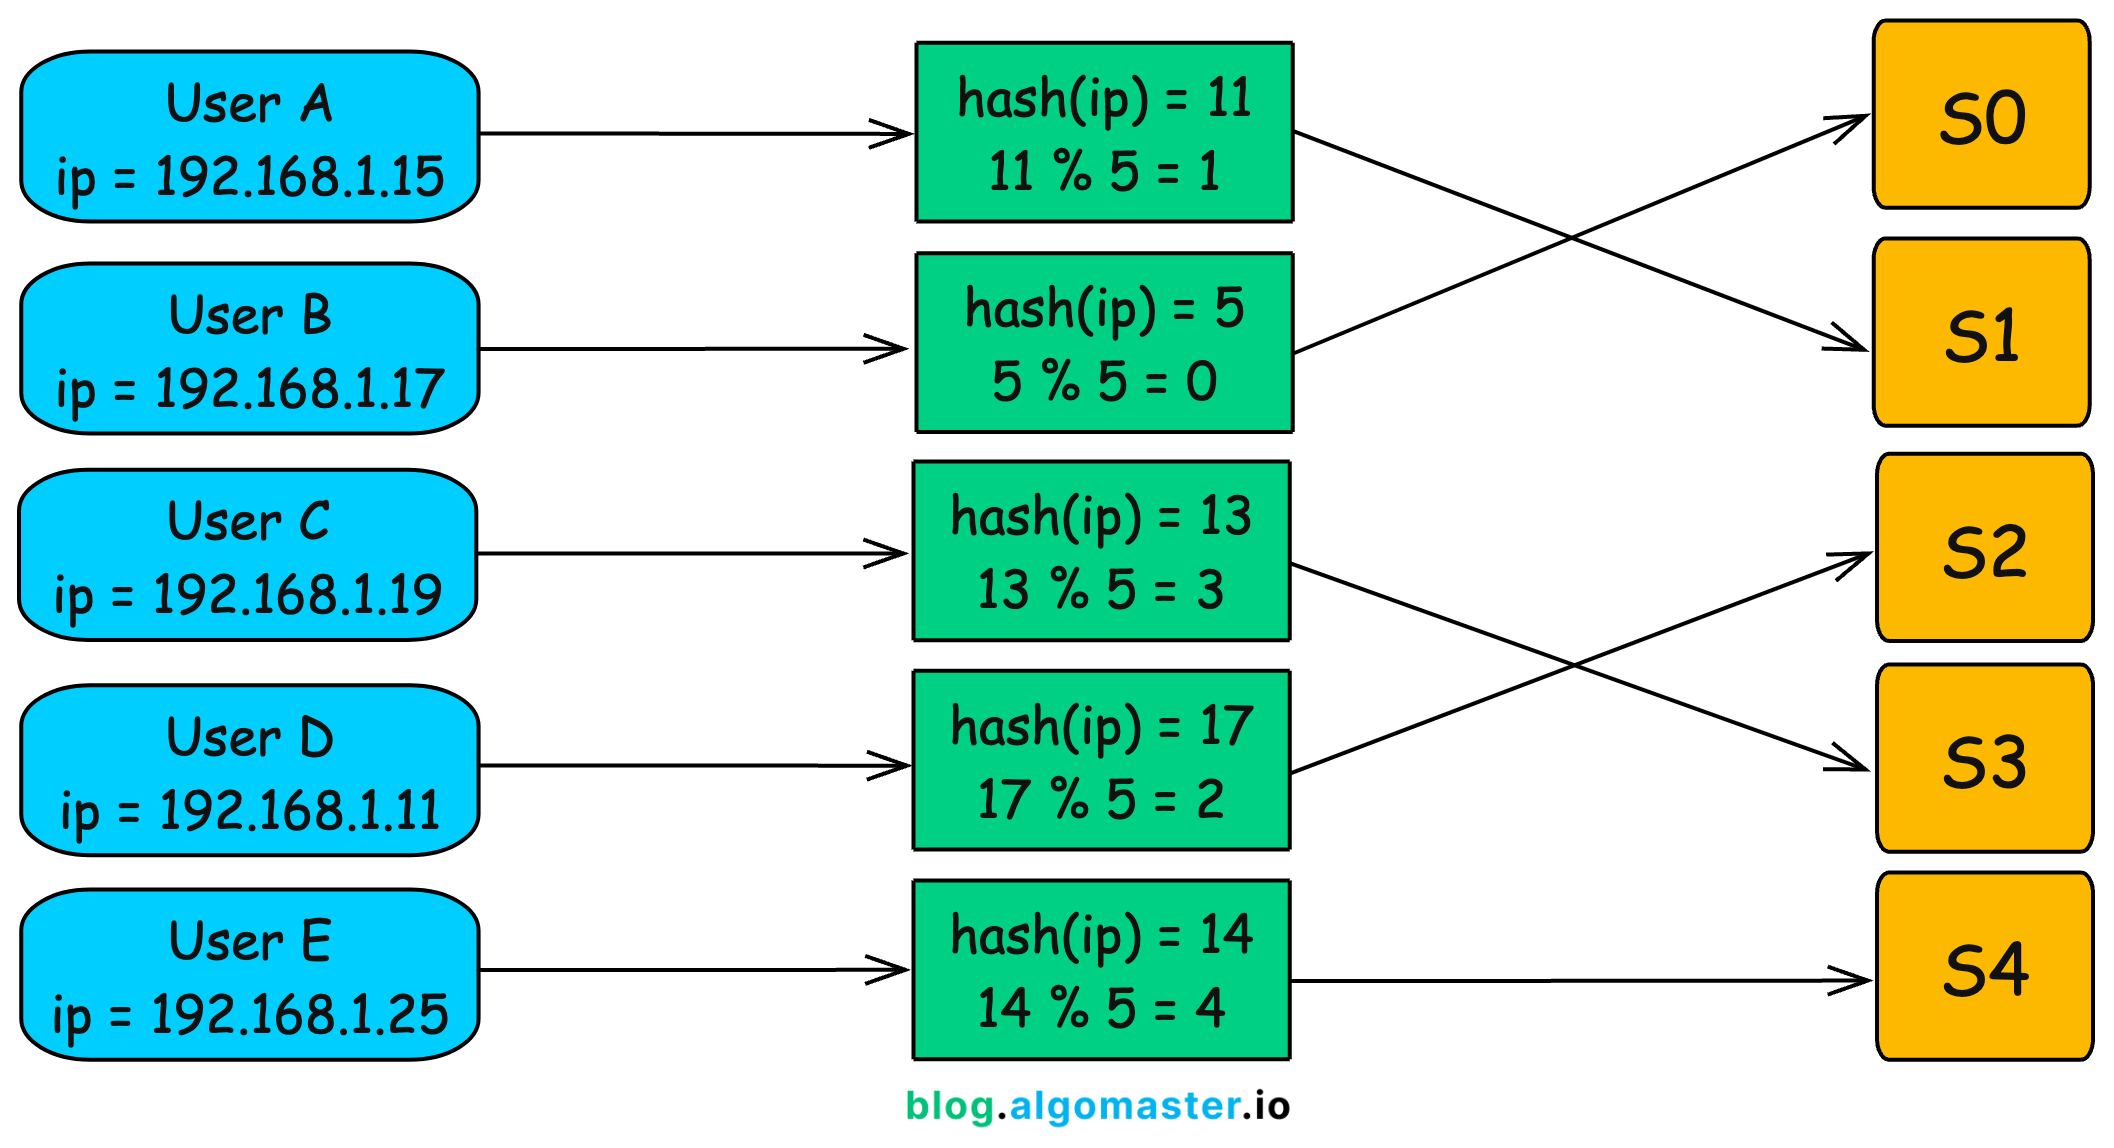

In [6]:
display(Image(filename='Utils/6.png'))

**Everything Works Fine… Until You Scale**

This approach works as long as the number of servers remains constant. 

But what happens when you add or remove a server???



## Scenario 1: Adding a New Server (S5)

1. As traffic increases, you decide to scale up by adding a new backend server (S5). Now, the hash function must be modified to use mod 6 instead of mod 5 since we have 6 servers now.

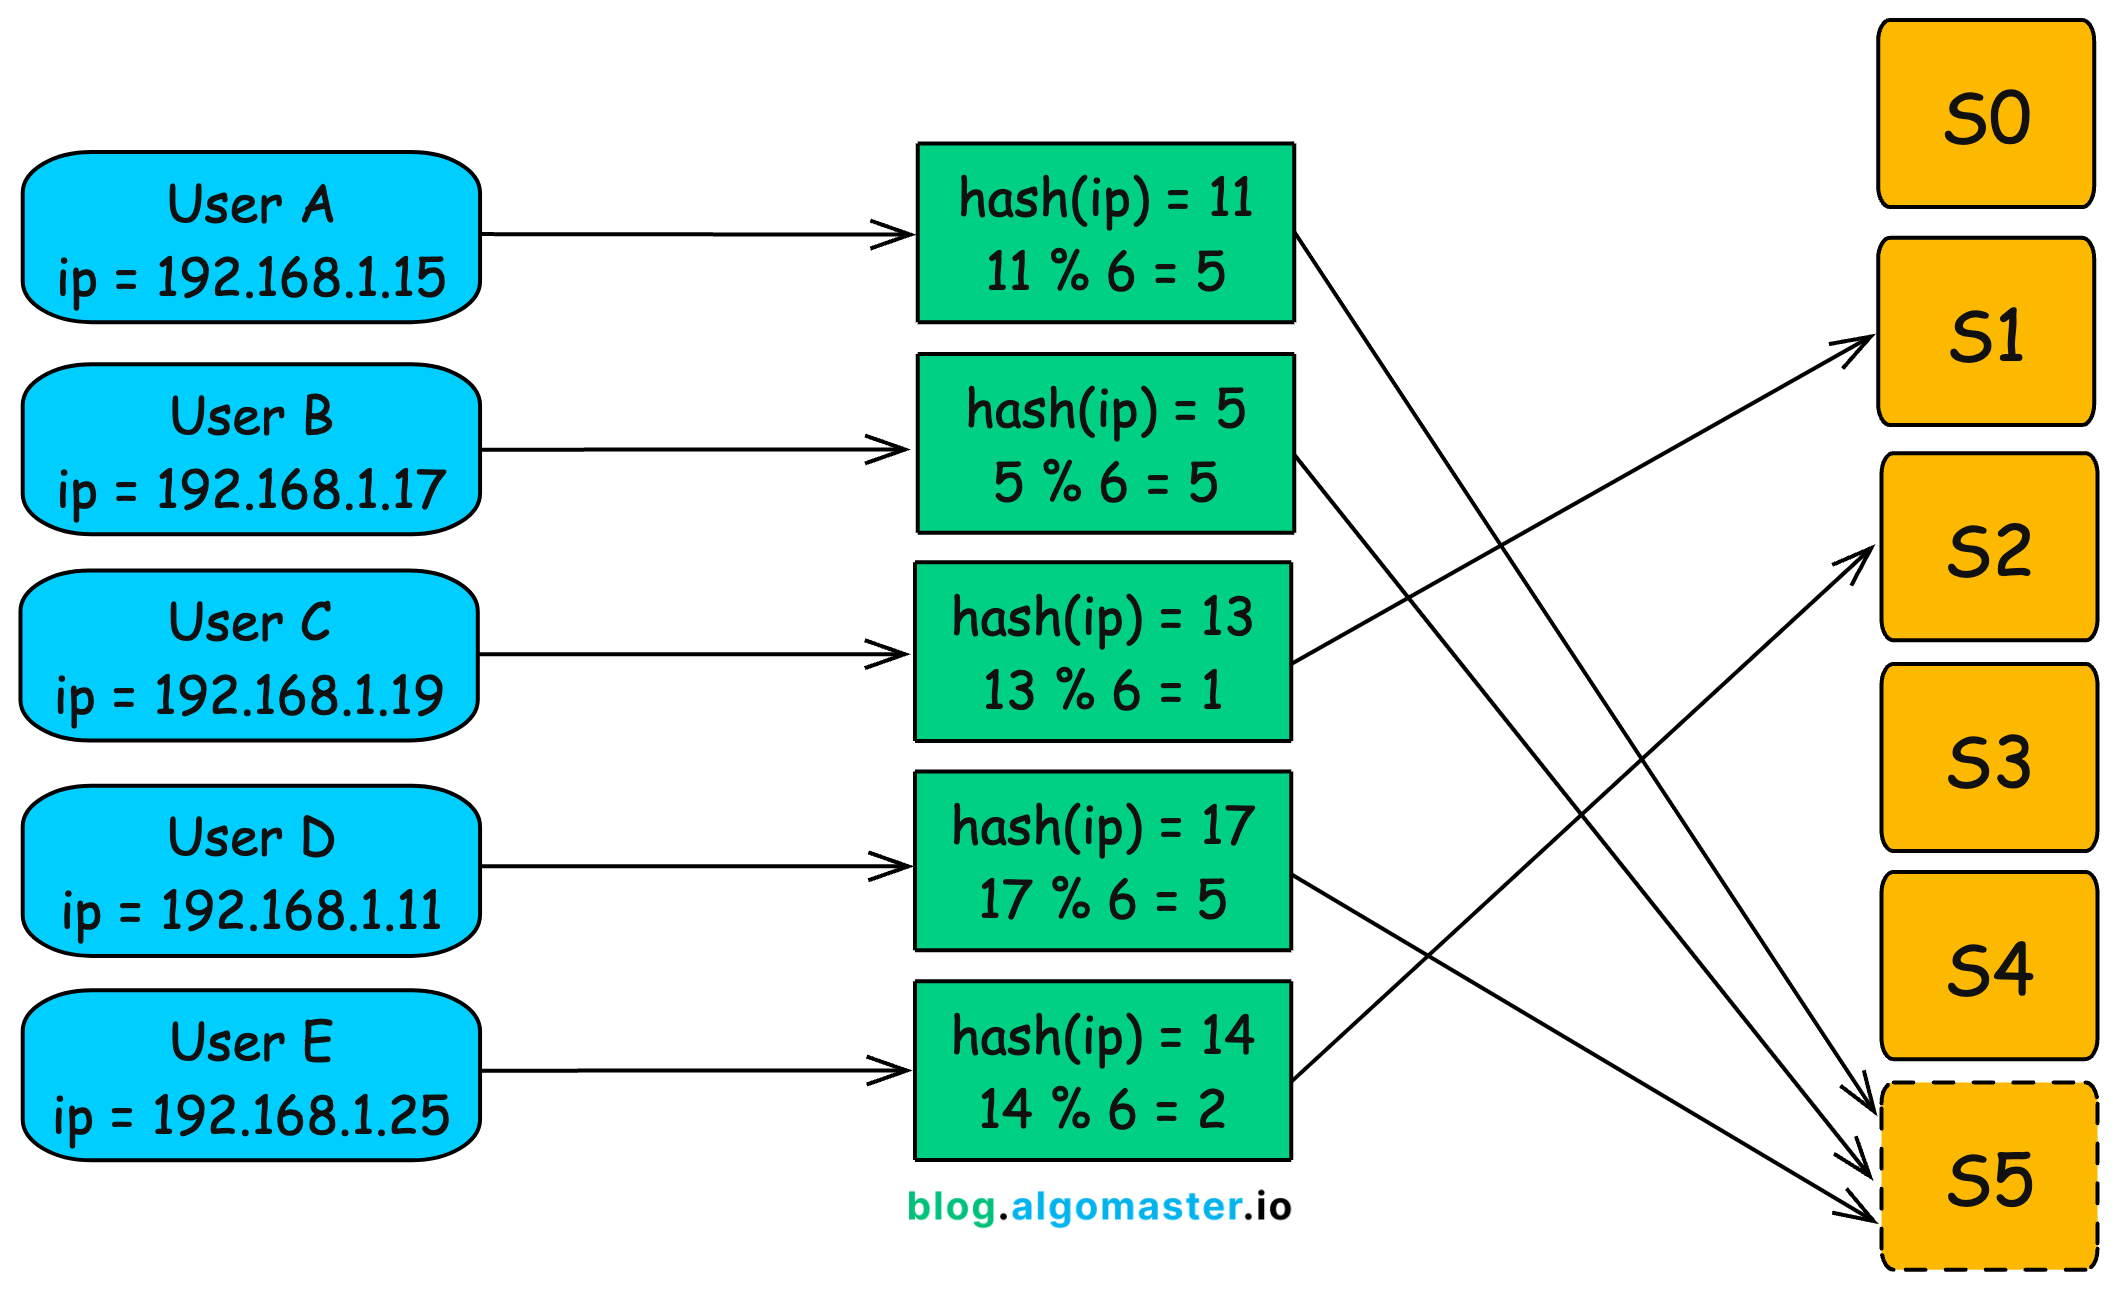

In [7]:
display(Image(filename='Utils/7.png'))

1. This seemingly simple change completely disrupts the existing mapping, causing most users to be reassigned to different servers.

2. This results into **massive rehashing, leading to high overhead, and potential downtime**.

## Scenario 2: Removing a Server (S4)

Now, let’s say one of the servers (S4) fails or is removed. The number of servers drops to 4, forcing the hash function to switch from mod 5 to mod 4.

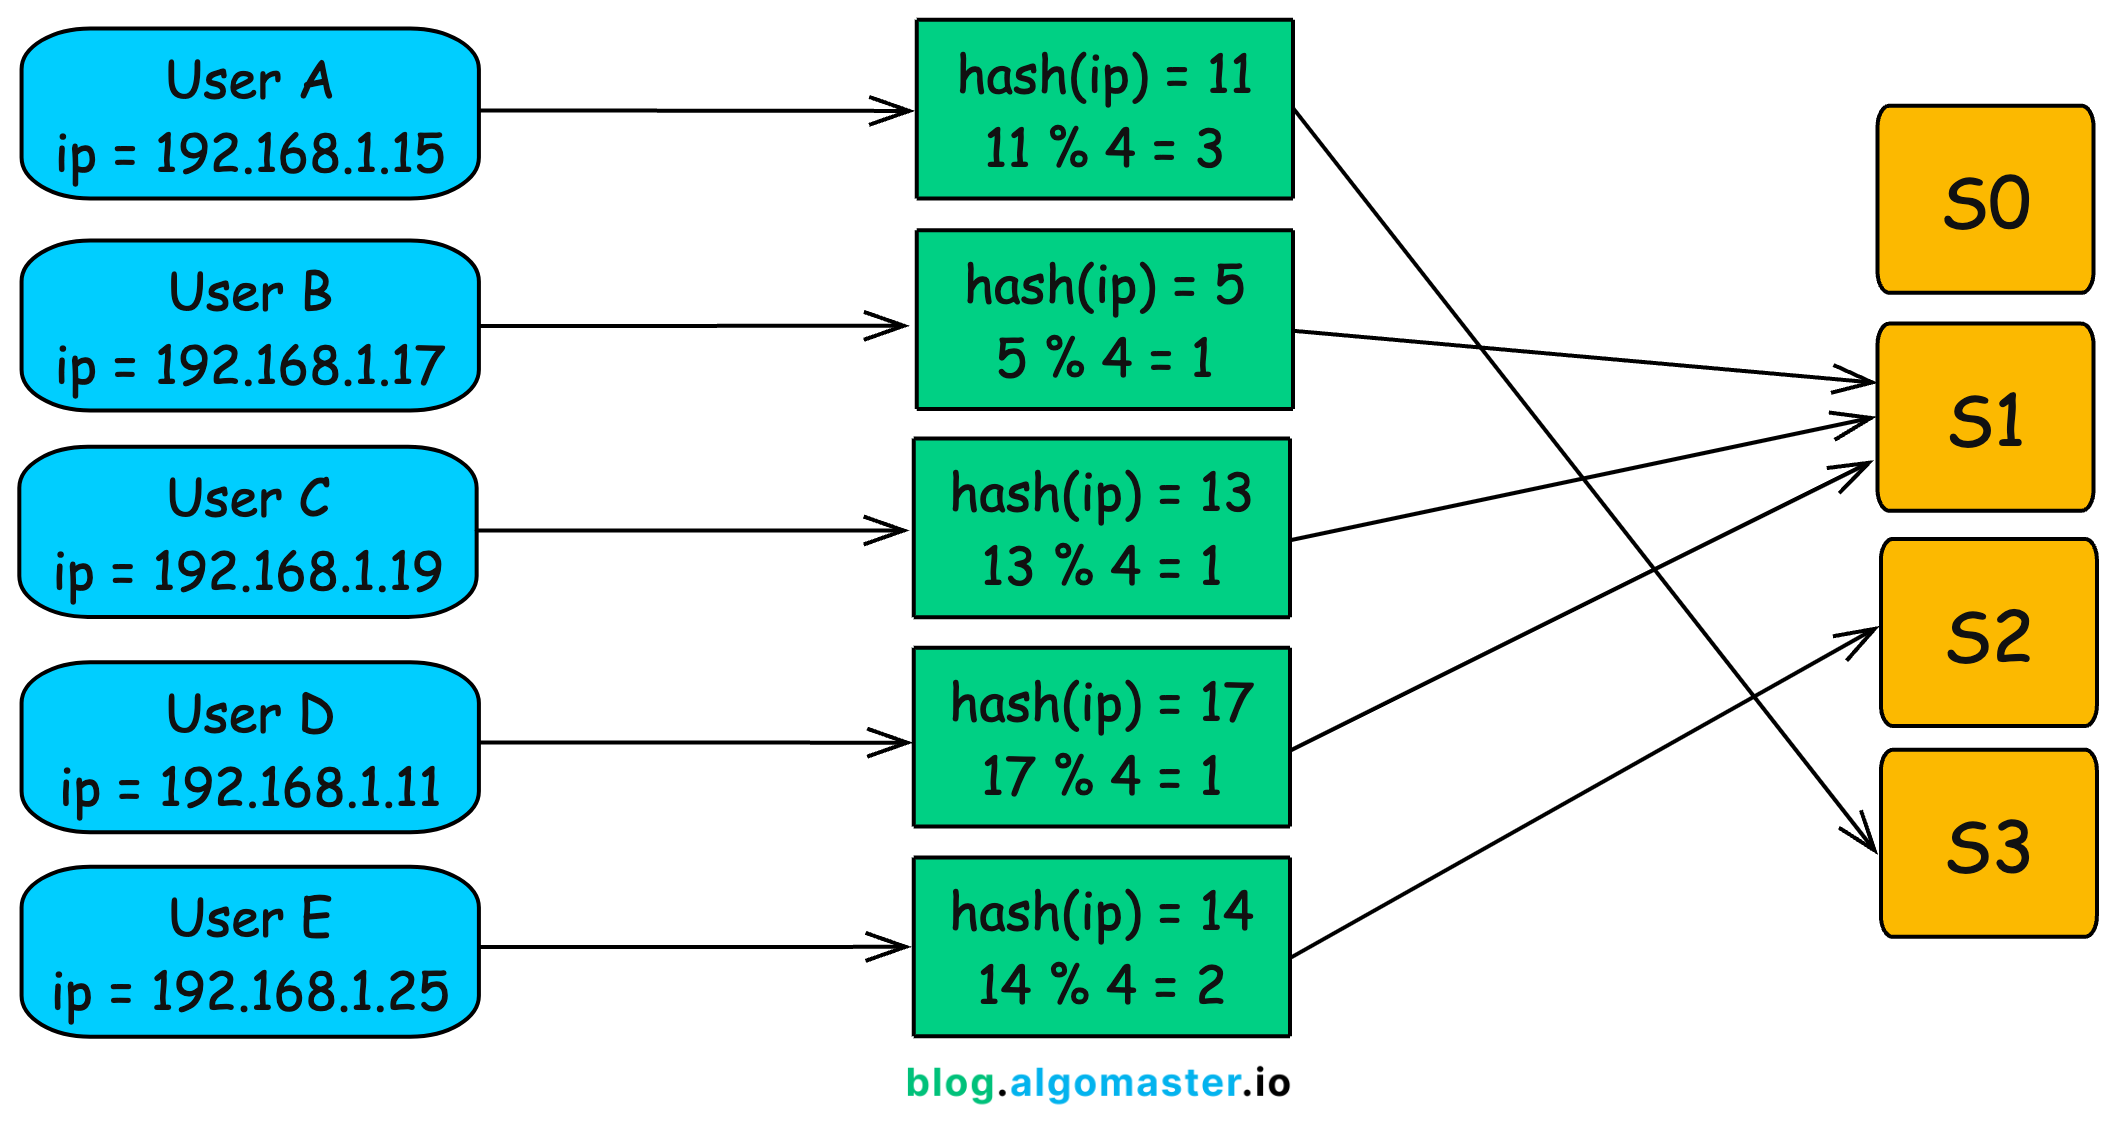

In [10]:
display(Image(filename='Utils/8.png'))

Even though only one server was removed, most users are reassigned to different servers. 

**This can cause:**

1. **Session Loss:** Active users may be logged out or disconnected.

2. **Cache invalidation:** Cached data becomes irrelevant, increasing database load.

3. **Severe performance degradation:** The system may struggle to run efficiently.

**The Solution: Consistent Hashing**

1. Consistent hashing offers a **more scalable and efficient solution by ensuring that only a small fraction of users** are reassigned when scaling up or down.

2. It performs really well when operated in dynamic environments, where **the system scales up and down frequentl**y.

# 2. How Consistent Hashing Works

1. Consistent hashing is a distributed hashing technique used to efficiently distribute data across multiple nodes (servers, caches, etc.).

2. It uses a circular hash space (hash ring) with a large and constant hash space.

3. Both nodes (servers, caches, or databases) and keys (data items) are mapped to positions on this hash ring using a hash function.

3. Unlike modulo-based hashing, where changes in the number of nodes cause large-scale remapping, consistent hashing ensures that only a small fraction of keys are reassigned when a node is added or removed, making it highly scalable and efficient.

**In consistent hashing, when the number of nodes changes, only k/n keys need to be reassigned, where k is the total number of keys and n is the total number of nodes.**

## 2.1 Constructing the Hash Ring

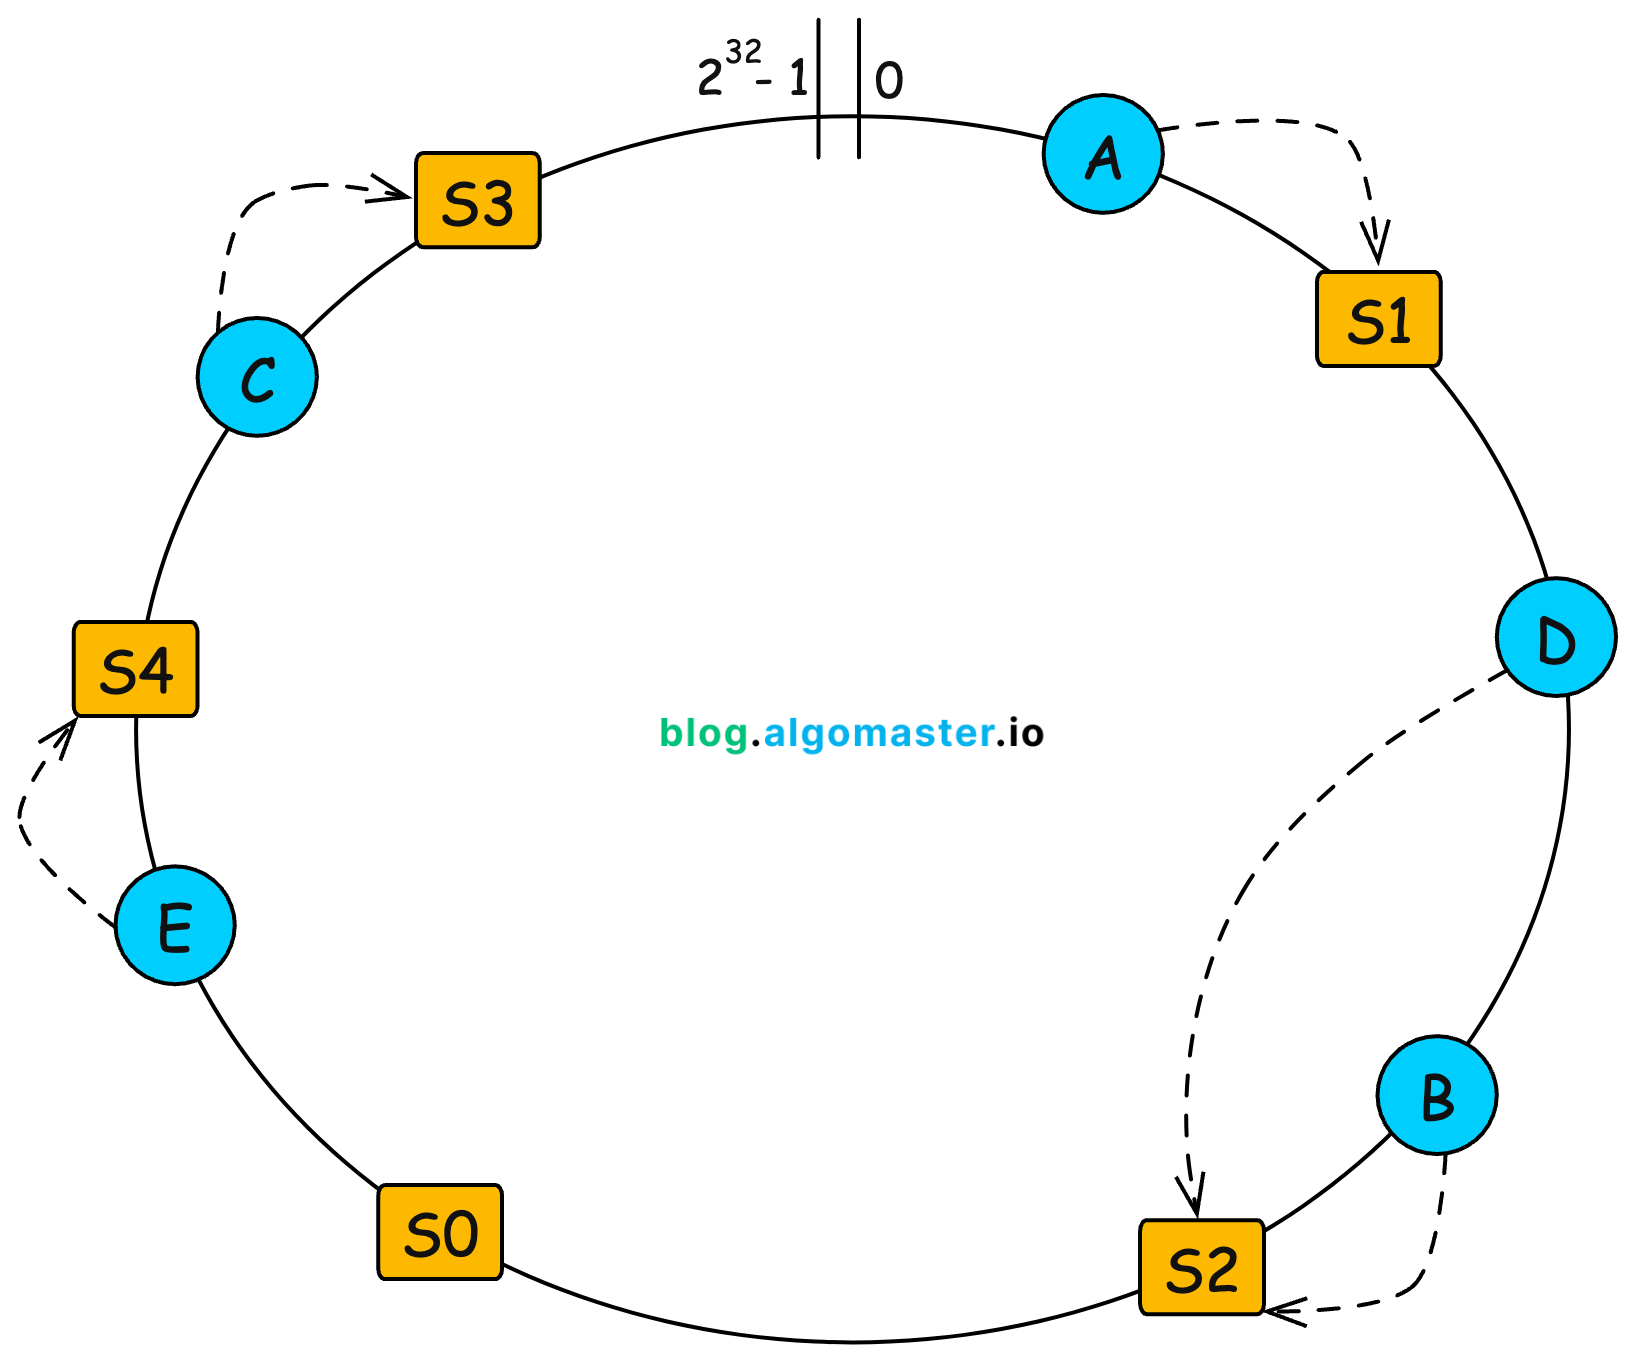

In [11]:
display(Image(filename='Utils/9.png'))



Instead of distributing keys based on Hash(key) mod N, consistent hashing places both servers and keys on a circular hash ring.

**Defining the Hash Space**

1. We use a large, fixed hash space ranging from 0 to 2^32 - 1 (assuming a 32-bit hash function).

2. This creates a circular structure, where values wrap around after reaching the maximum limit.

**Placing Servers on the Ring**

1. Each server (node) is assigned a position on the hash ring by computing Hash(server_id).

2. Using the above example with 5 servers (S0, S1, S2, S3, S4), the hash function distributes them at different positions around the ring.

**Mapping Keys to Servers**

1. When a key is added, its position is determined by computing Hash(key).

2. Example: a user’s request is assigned a position on the ring based on the hash of their IP address: Hash(IP Address)

3. We then move clockwise around the ring until we find the next available server.

4. The key (or request) is assigned to this server for storage or retrieval.

5. Note: In case a key’s hash falls directly on a node’s position, it belongs to that node.

## 2.2 Adding a New Server


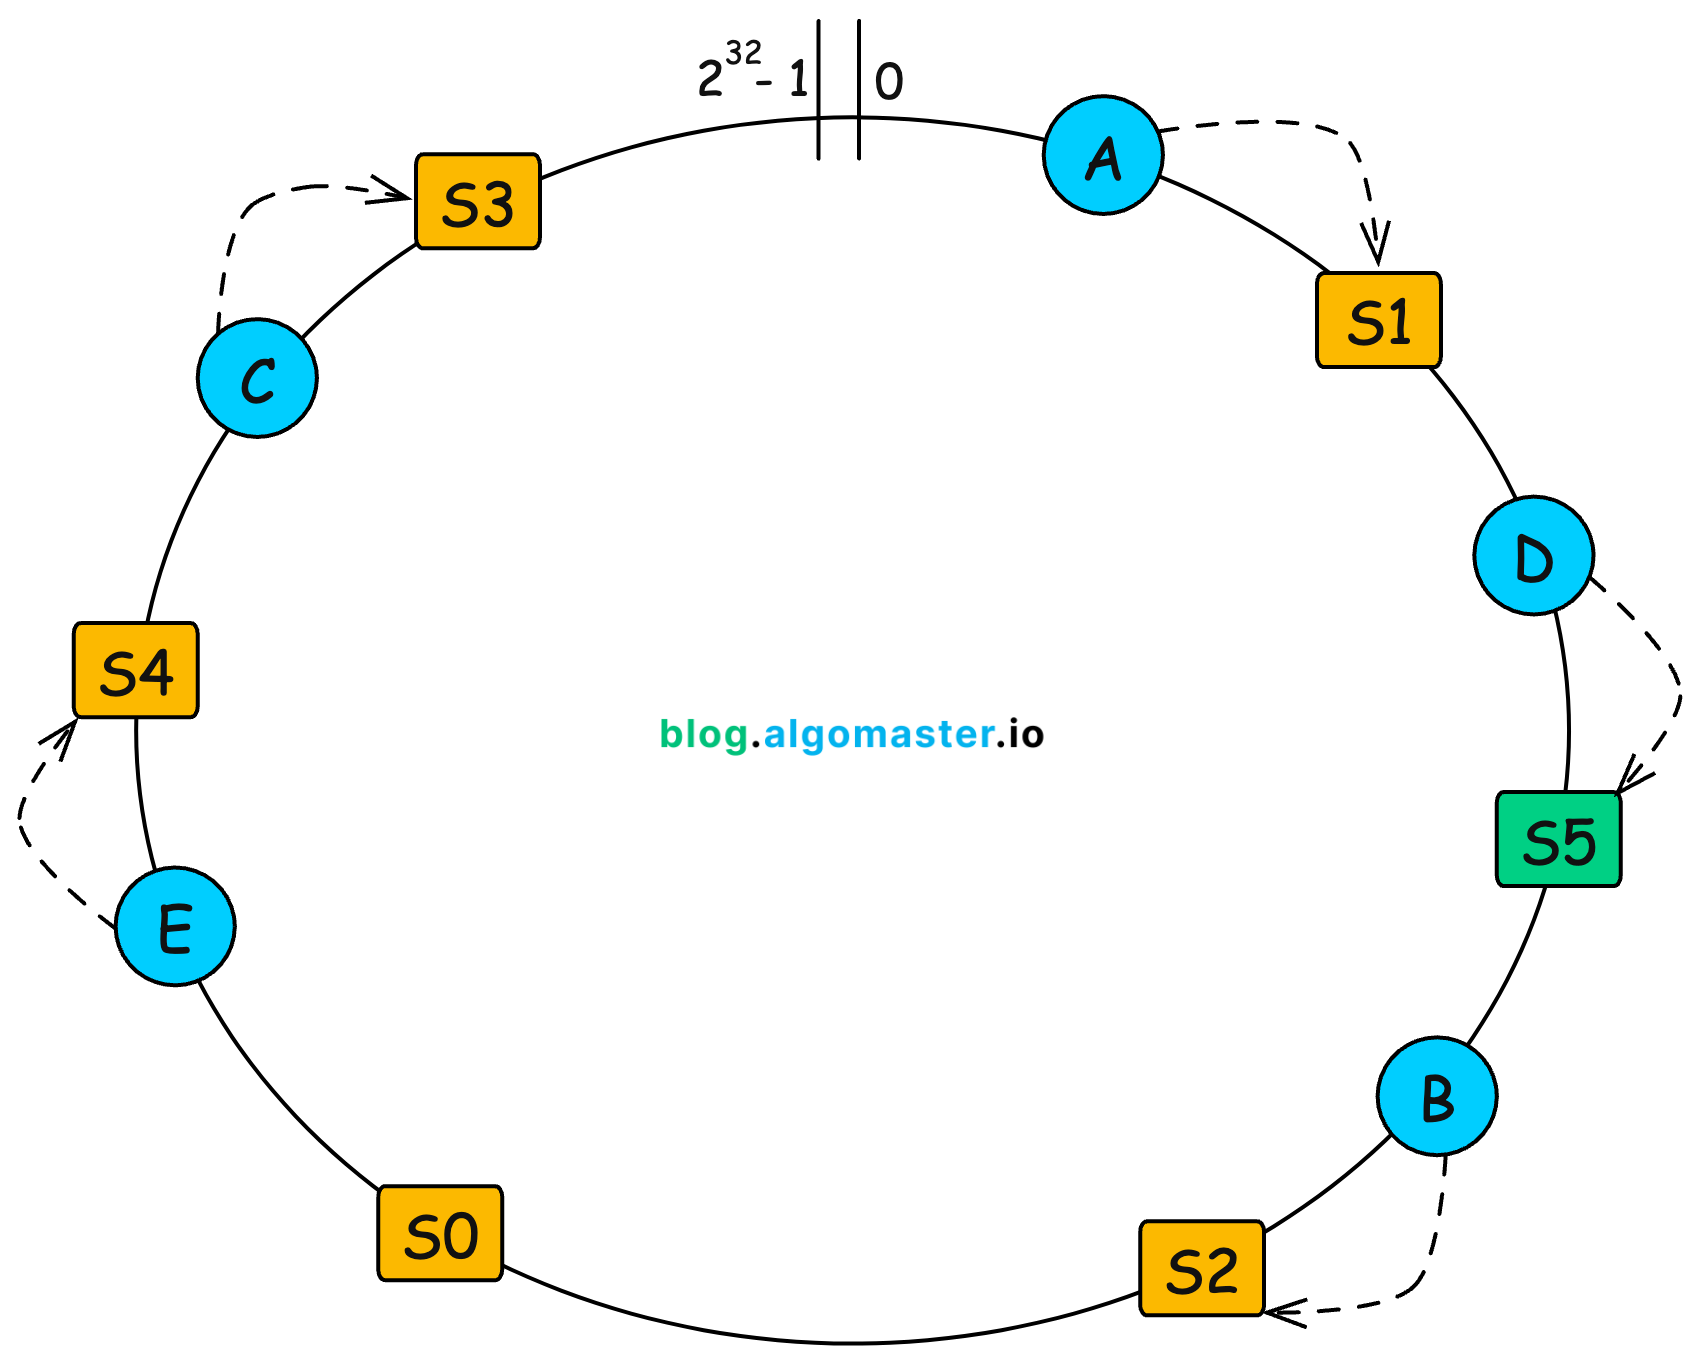

In [12]:
display(Image(filename='Utils/10.png'))


Suppose we **add a new server (S5)** to the system.

1. The position of S5 falls between S1 and S2 in the hash ring.

2. S5 takes over all keys (requests) that fall between S1 and S5, which were previously handled by S2.

3. Example: User D’s requests which were originally assigned to S2, will now be redirected to S5.

This demonstrates how consistent hashing **efficiently redistributes keys with minimal disruption**, ensuring that **only a small subset of keys are reassigned** when new servers are added.

## 2.3 Removing a Node


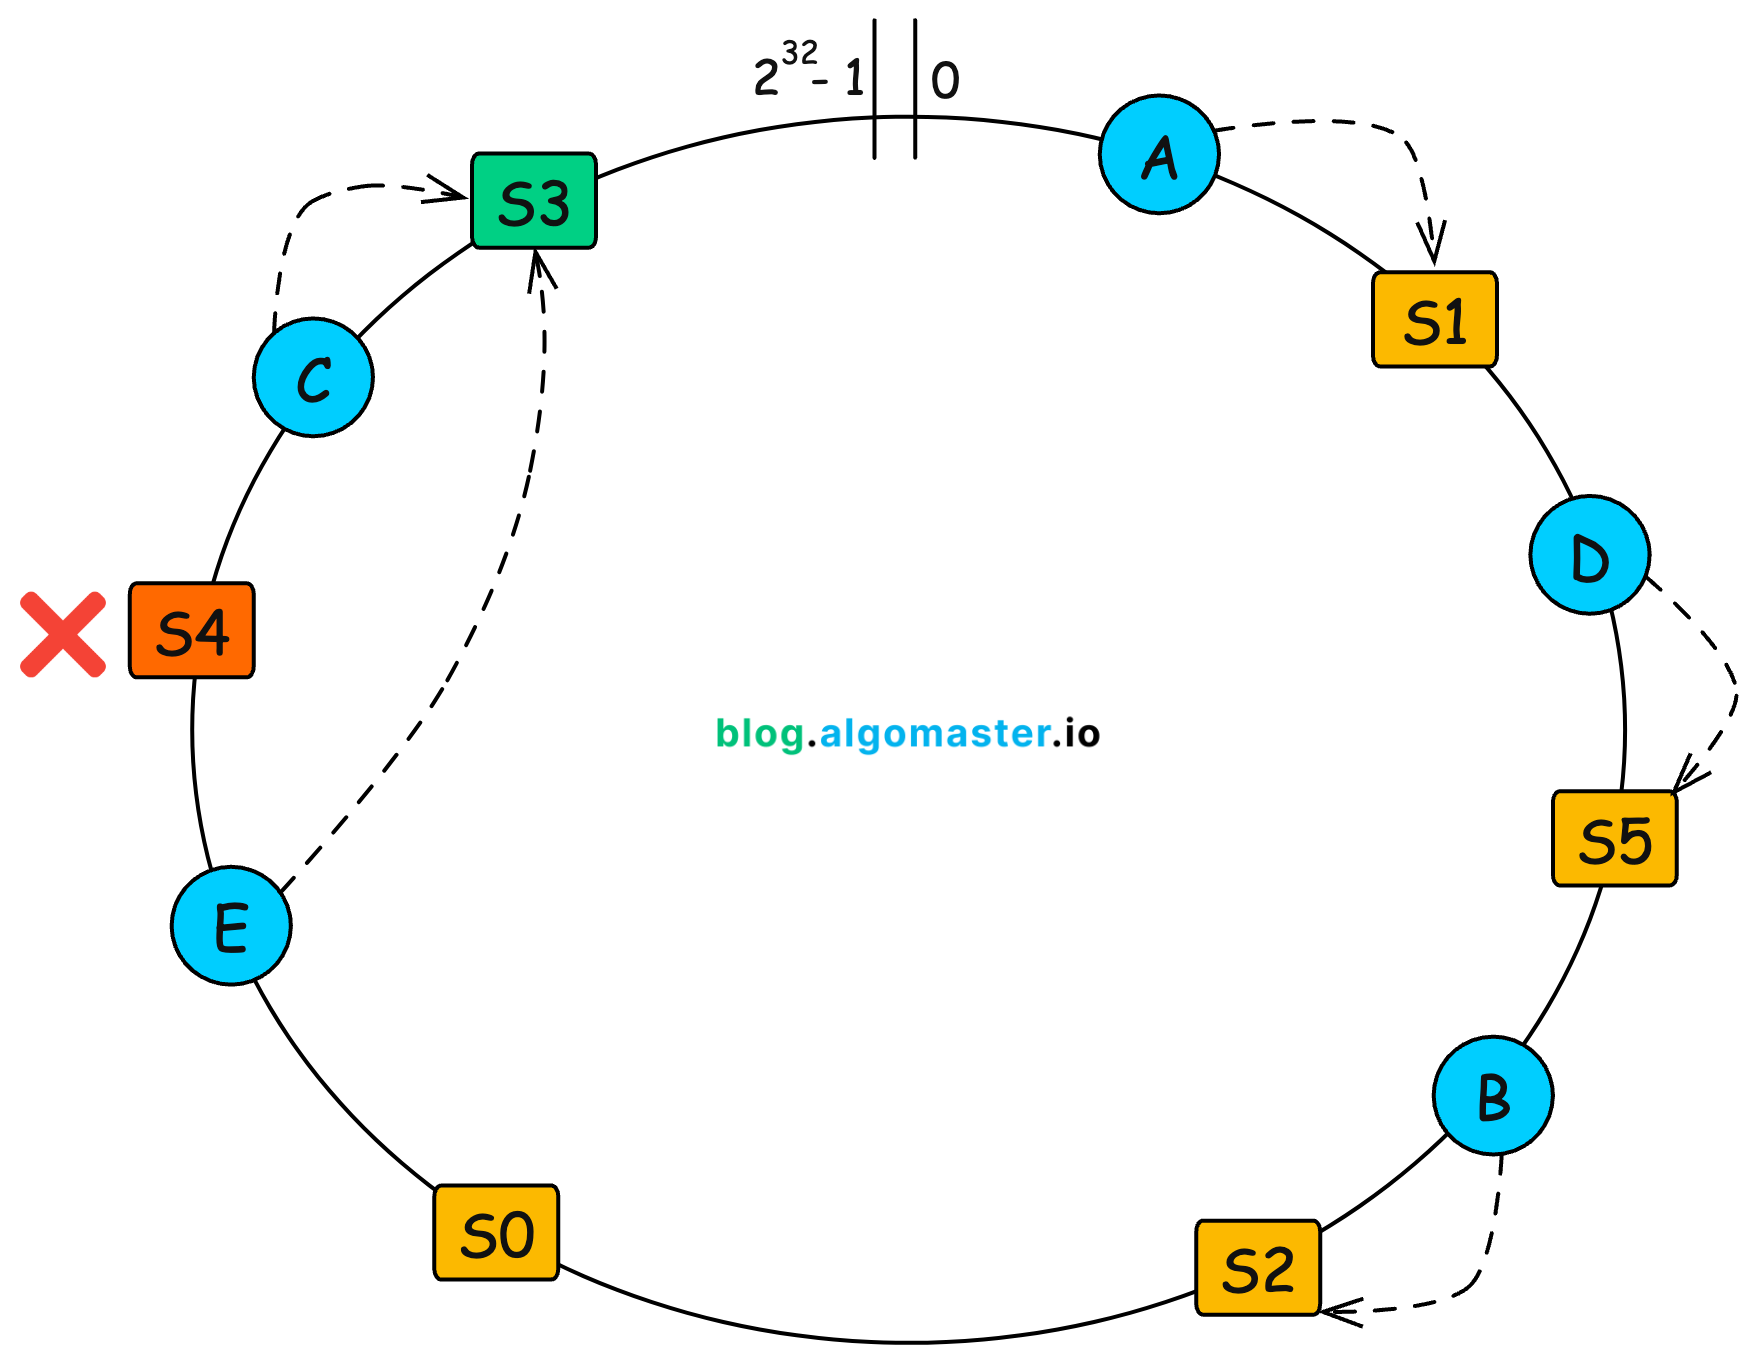

In [13]:
display(Image(filename='Utils/11.png'))


When a server, such as S4, **fails or is removed from the system**:

1. All keys previously assigned to S4 are reassigned to the next available server in the ring (S3).

2. Only the keys (requests) that were mapped to S4 need to move, while all other keys remain unaffected.

This results in **minimal data movement**, unlike traditional hashing where removing a node would require reassigning most keys.

# 3. Virtual Nodes


In basic consistent hashing, **each server is assigned a single position on the hash ring**. However, this can lead to **uneven data distribution**, especially when:

1. The number of servers is small.

2. Some servers **accidentally get clustered together, creating hot spots**.

3. A server is removed, **causing a sudden load shift** to its immediate neighbor.



**Virtual nodes (VNodes) are a technique used in consistent hashing to improve load balancing and fault tolerance by distributing data more evenly across servers.**

**How Virtual Nodes Work**

1. Instead of assigning one position per server, each physical server is assigned multiple positions (virtual nodes) on the hash ring.

2. Each server is hashed multiple times to different locations on the ring.

3. When a request (key) is hashed, it is assigned to the next virtual node in a clockwise direction.

4. The request is then routed to the actual server associated with the virtual node.


Example 1 : 


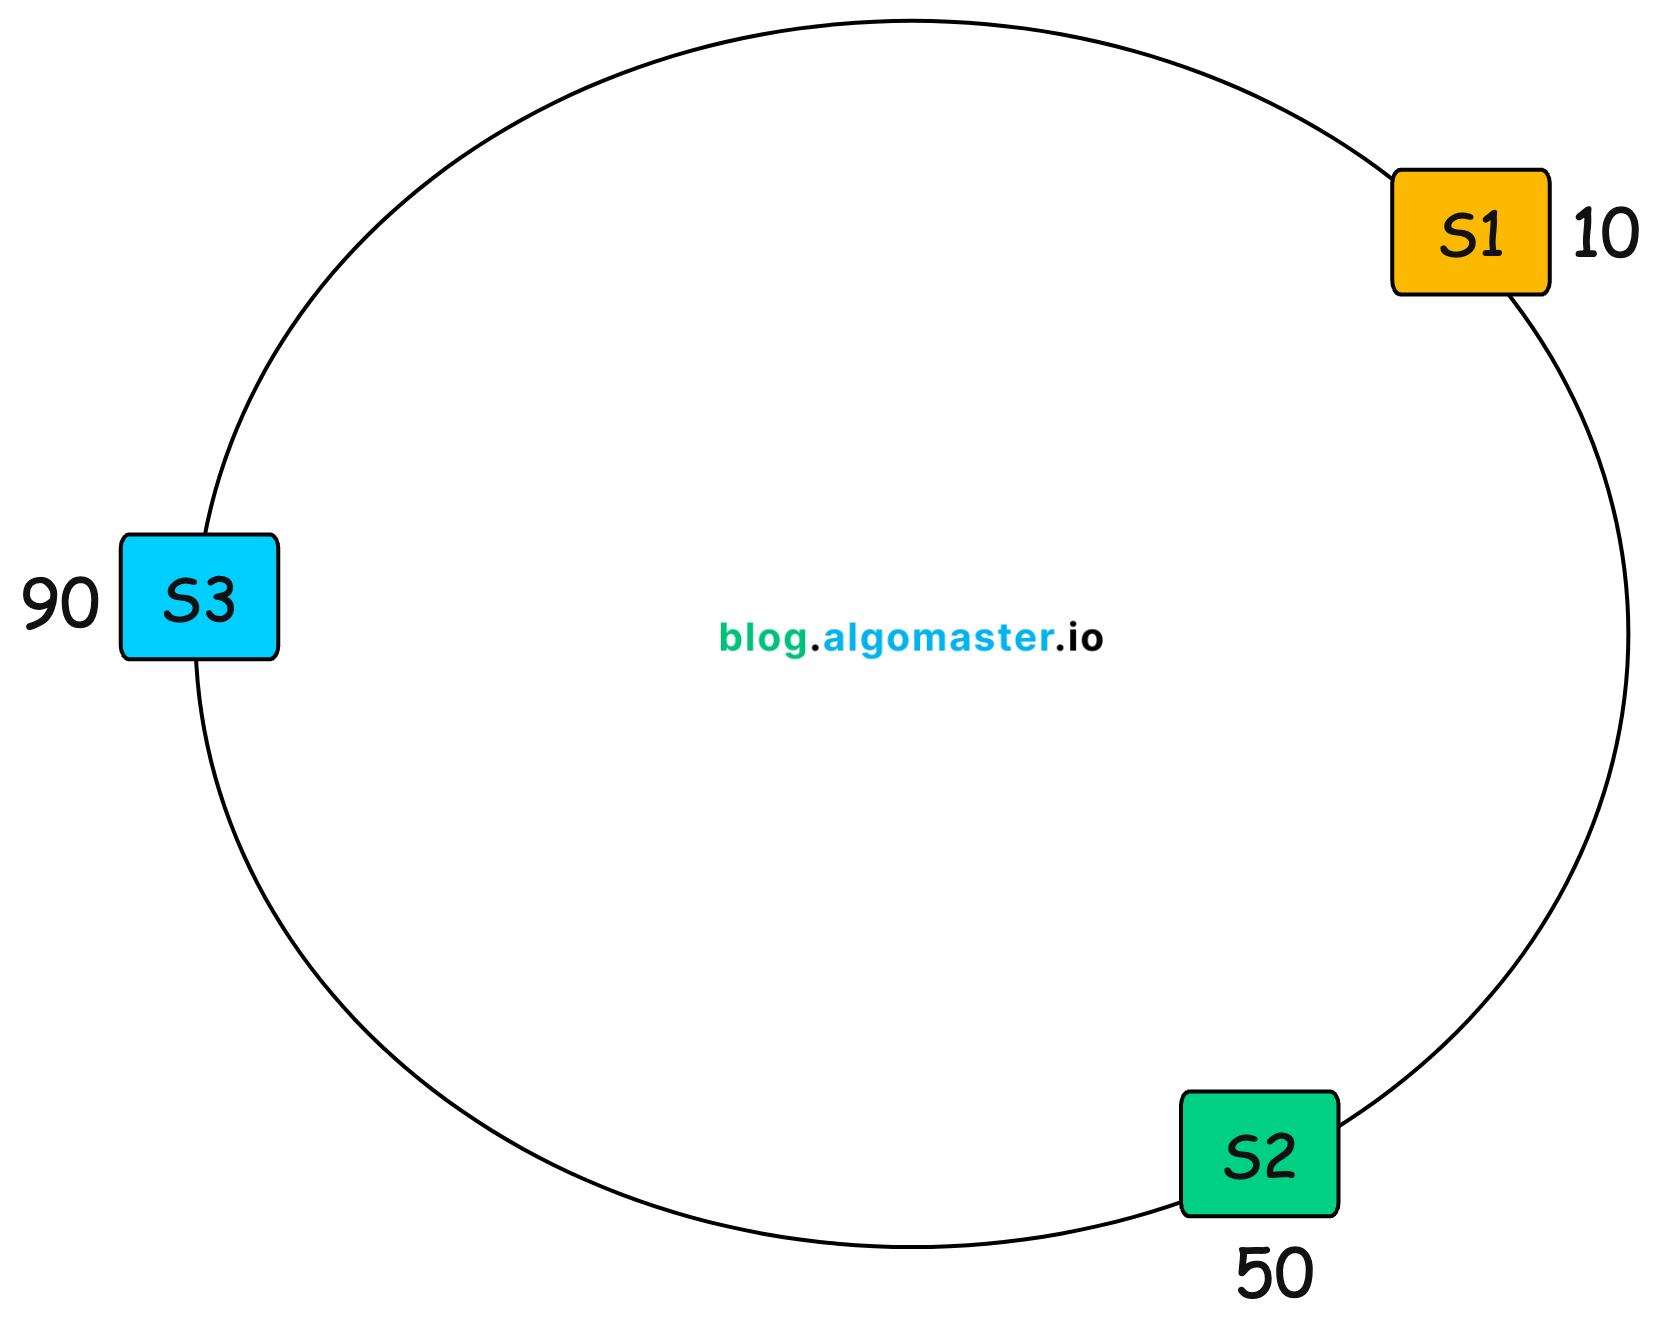

In [14]:
display(Image(filename='Utils/12.png'))


Assume we have three physical servers (S1, S2, S3). Without virtual nodes, their positions might be:

S1 → Position 10

S2 → Position 50

S3 → Position 90

If S1 fails, all its keys must be reassigned to S2, which can create an overload.

**With virtual nodes, each server is hashed multiple times**:

Example 2 : 

S1-1 → Position 10  S1-2 → Position 70  S1-3 → Position 120

S2-1 → Position 50  S2-2 → Position 80  S2-3 → Position 160

S3-1 → Position 30  S3-2 → Position 90  S3-3 → Position 140

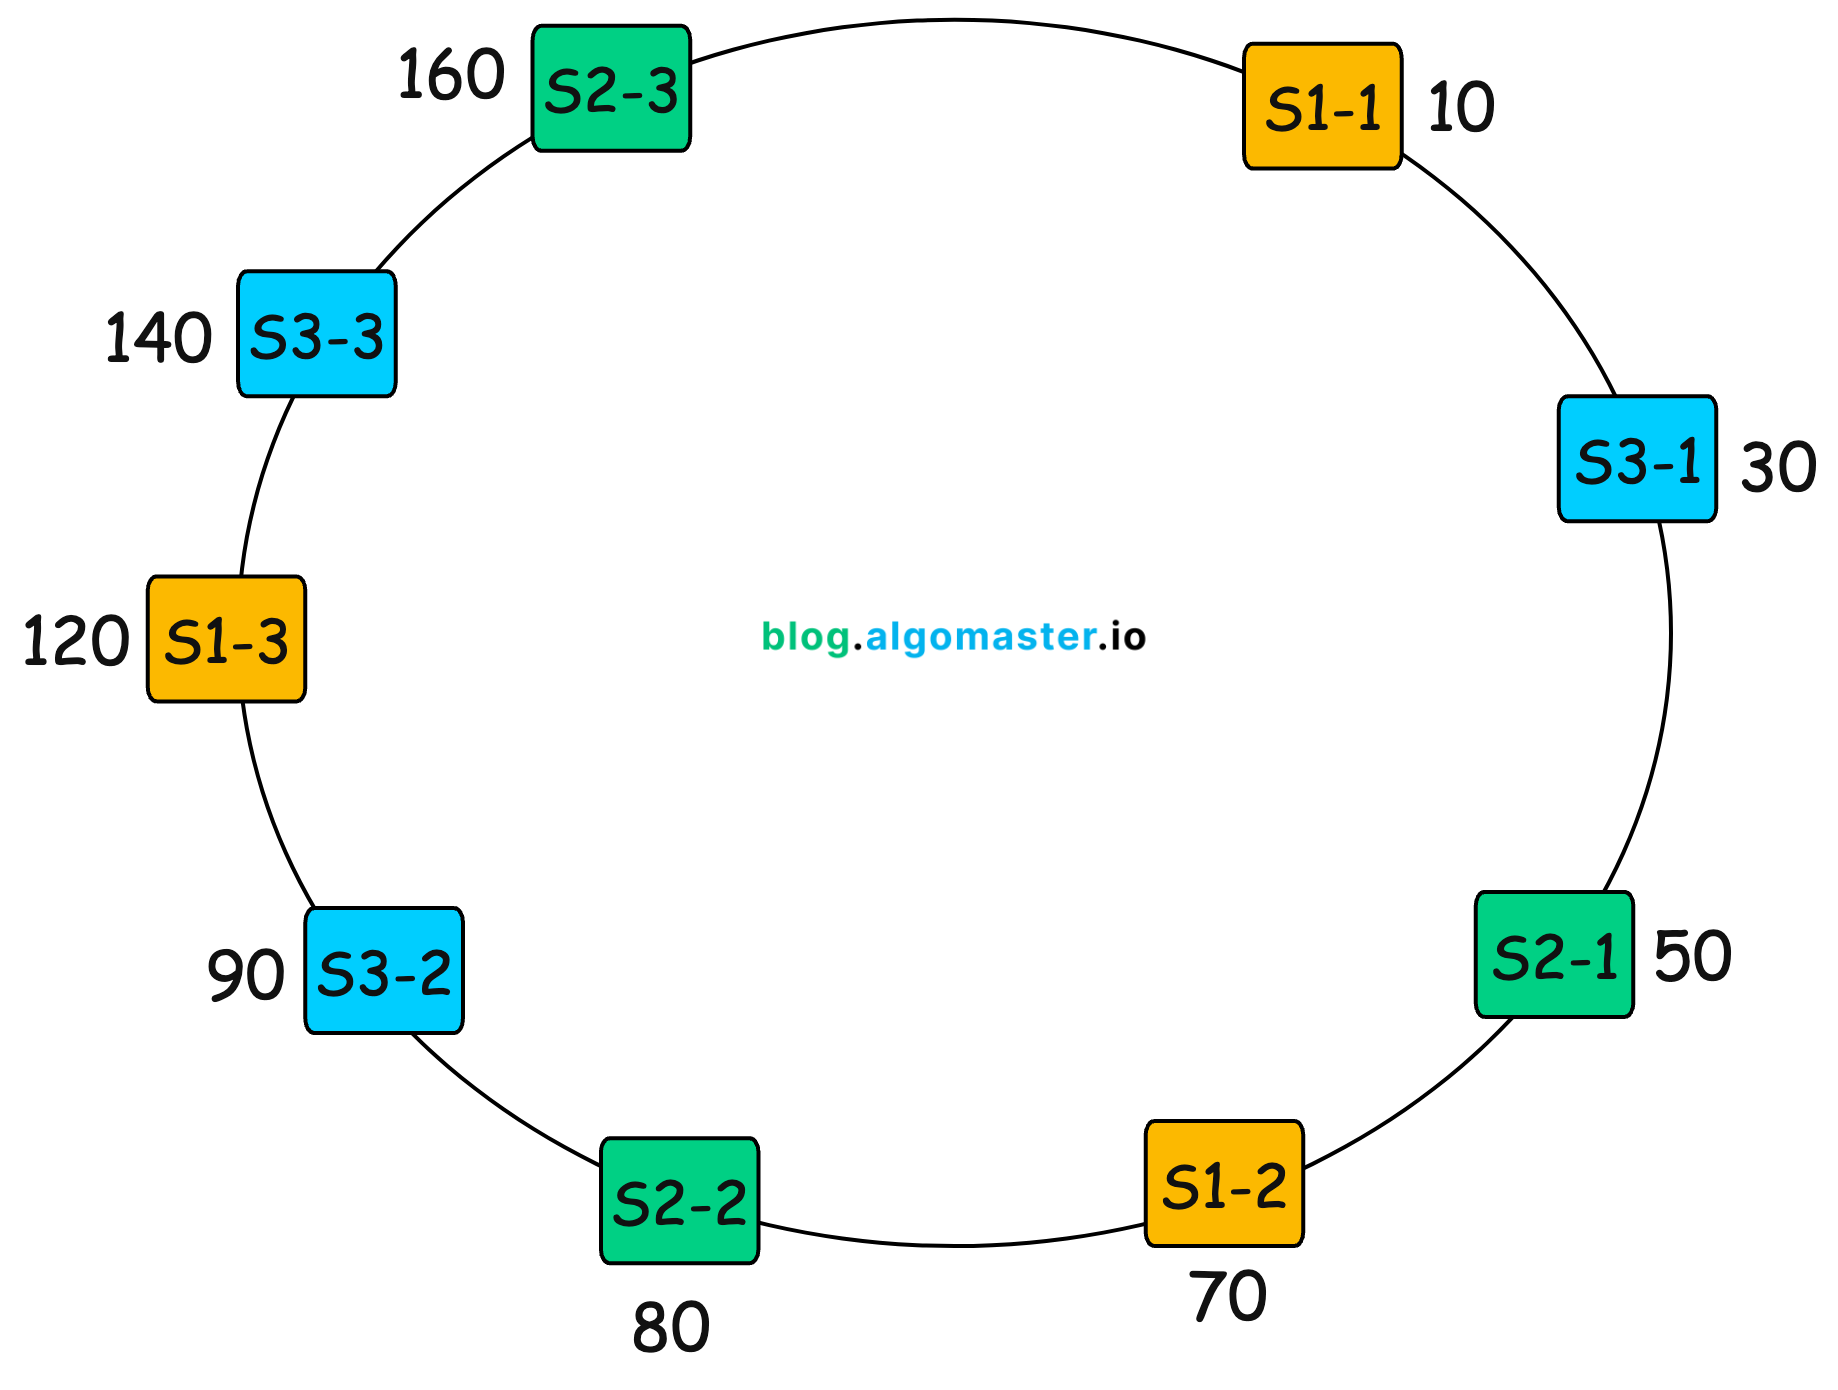

In [15]:
display(Image(filename='Utils/13.png'))

Now, instead of just one point, S1 is represented at multiple positions, making the distribution more even.

**If S1 fails, its keys are more evenly redistributed among S2 and S3, rather than all going to S2.**

# 4. Code Implementation (Python)

## Explanation:

**1. Key Components** : 

   1. Hash Ring (self.ring): Stores hash values → server mappings. Uses virtual nodes (replicas) for better load balancing.

   2. Sorted Keys (self.sorted_keys): Maintains a sorted list of hash values for efficient lookups.

   3. Server Set (self.servers): Tracks active physical servers.

**2. Initialization (__init__)** : 

   1. Calls add_server() for each server, hashing it multiple times (based on num_replicas) to ensure even distribution.

**3. Hashing Function (_hash)** : 

   1. Uses MD5 hashing to convert strings into large integers for consistent placement on the hash ring.

**4. Adding a Server (add_server)** : 

   1. Generates multiple hash values for each server (server-0, server-1, etc.).
   
   2. Stores these in self.ring and maintains a sorted order in self.sorted_keys for fast lookup.

**5. Removing a Server (remove_server)** : 
   
   1. Deletes the server’s hash values and its virtual nodes from self.ring and self.sorted_keys.

**6. Getting a Server (get_server)**;

   1. Hashes the input key and finds the closest clockwise server using bisect.bisect(). 
    
   2. Wraps around to the first node if necessary.